In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import mat73
import numpy as np
import pandas as pd

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.utils import plot

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH


#### Load data and preprocess

In [4]:
data = DataClass(config)

nMax = 2
df = None

for i in range(1, nMax):
    participant = f"amap{i:02}"
    PREFIX = f"rats_data/{participant}/*"

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*auc_table.csv"))[0]
    temp_df = pd.read_csv(fpath)

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*ep_matrix.mat"))[0]
    data_dict = mat73.loadmat(fpath)
    temp_mat = data_dict["ep_sliced"]

    if df is None:
        time = data_dict["t_sliced"]
    else:
        assert((data_dict["t_sliced"] == time).all())

    temp_df["participant"] = participant
    temp_df["method"] = temp_df.channel2_laterality

    idx = temp_df.channel1_segment.isna()
    temp_df = temp_df[idx].copy()
    temp_mat = temp_mat[idx, :, :]

    if df is None:
        df = temp_df.copy()
        mat = temp_mat
    else:
        df = pd.concat([df, temp_df], ignore_index=True).copy()
        mat = np.vstack((mat, temp_mat))

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)

# df = df[df.participant.isin([0, 1])].copy()
# # df = df[df.compound_position.isin([0, 1, 2, 5])].copy()
# df = df[df.compound_position.isin([2, 5])].copy()
df.reset_index(drop=True, inplace=True)

2023-05-24 10:06:51,335 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-24 10:06:51,341 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-24 10:06:51,342 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


2023-05-24 10:06:51,701 - hb_mep.utils.utils - INFO - func:plot took: 0.29 sec


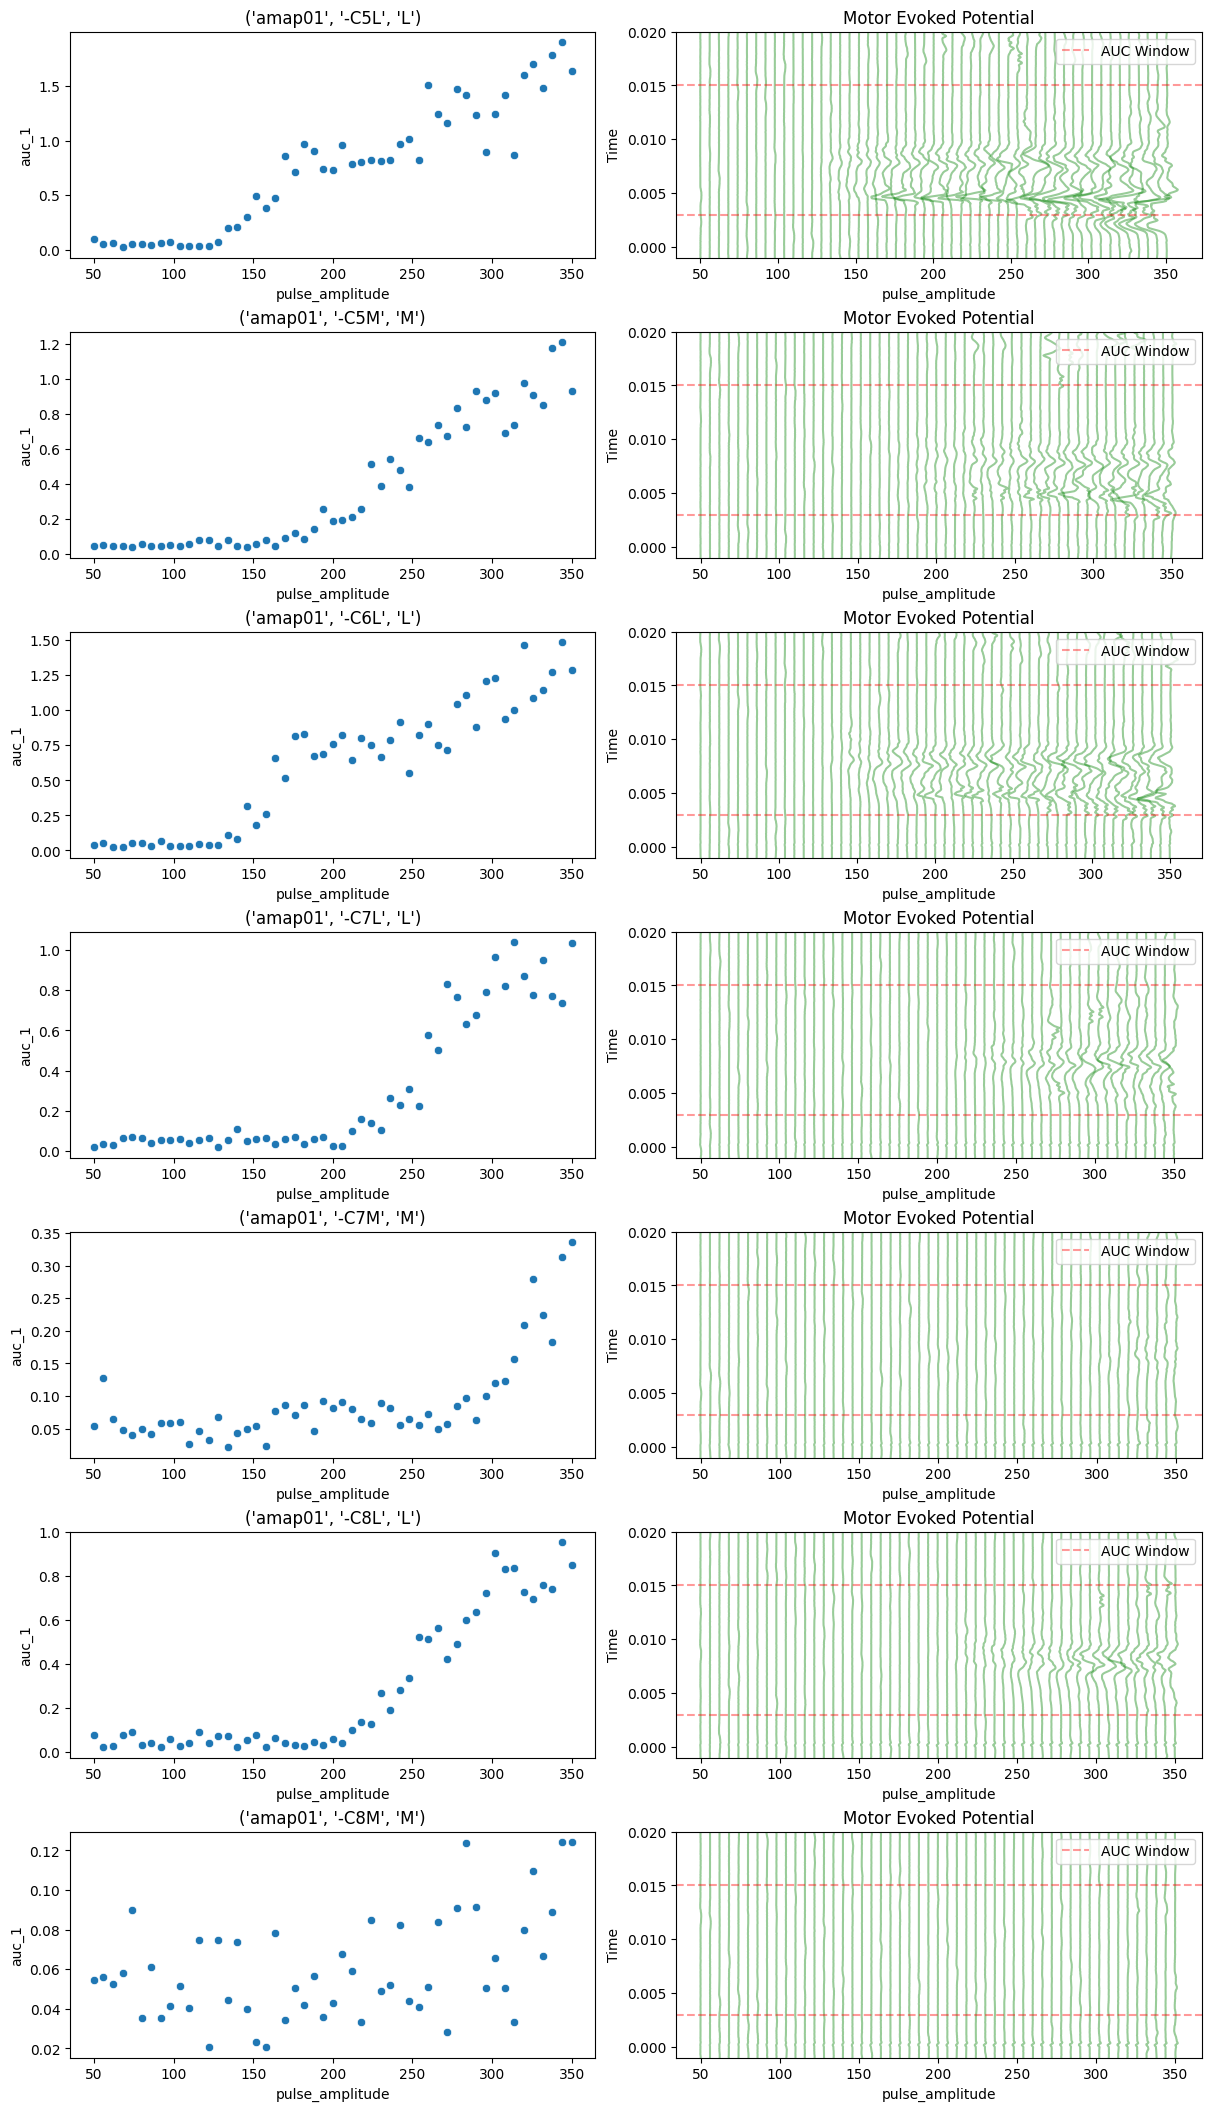

In [5]:
plot(df, encoder_dict=encoder_dict, mat=mat[:, :, 0], time=time);

2023-05-24 10:04:18,929 - hb_mep.utils.utils - INFO - func:plot took: 0.16 sec


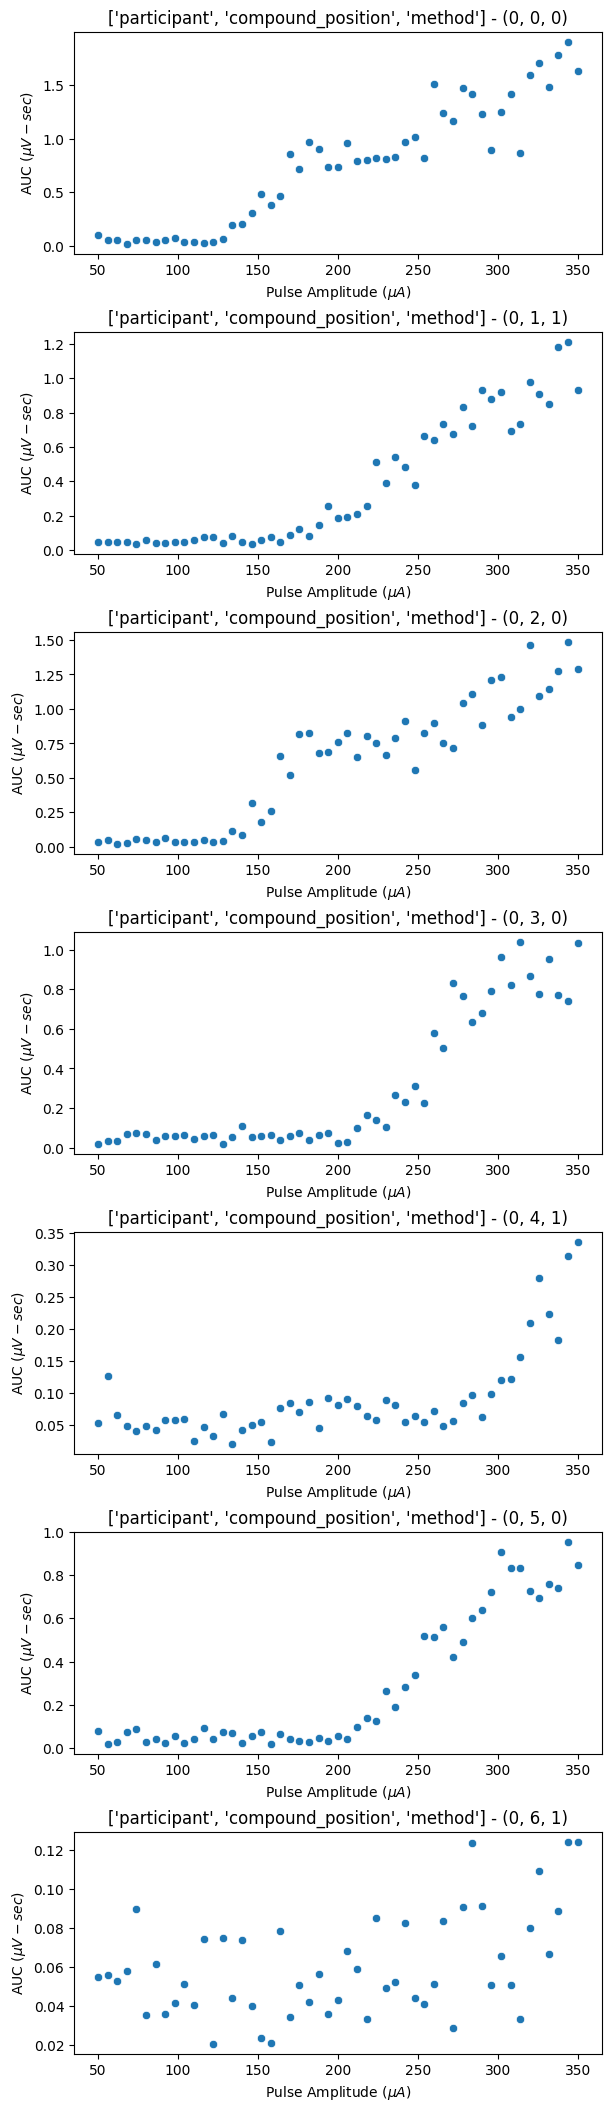

In [6]:
plot(df);

#### Plot data

In [6]:
# plot(df, encoder_dict=encoder_dict);

#### Initialize model

In [6]:
model = SaturatedReLU(config)

#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-23 10:31:56,168 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-23 10:31:56,169 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 10:31:56,169 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 10:31:56,170 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-23 10:31:56,170 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-23 10:31:56,204 - hb_mep.models.rats.saturated_relu - INFO - Running inference with Saturat

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Diagnostics

In [ ]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
             a[0,0,0]    120.75      4.95    121.75    113.17    127.99   3998.11      1.00
             a[0,1,0]    144.59     33.26    144.39     90.87    198.51  11406.64      1.00
             a[1,0,0]    144.61     33.07    144.19     89.05    196.54  11456.29      1.00
             a[1,1,0]    166.49      2.61    166.43    162.18    170.82  13906.18      1.00
            a_mean[0]    144.37     18.12    144.42    116.12    174.99   9415.34      1.00
           a_scale[0]     26.46      9.60     24.89     11.92     40.95  10312.57      1.00
             b[0,0,0]      0.01      0.00      0.01      0.01      0.01   5300.74      1.00
             b[0,1,0]      0.02      0.03      0.01      0.00      0.04  13128.41      1.00
             b[1,0,0]      0.02      0.03      0.01      0.00      0.04  13251.91      1.00
             b[1,1,0]      0.01      0.00      0.01      0.01      0.01  14239.

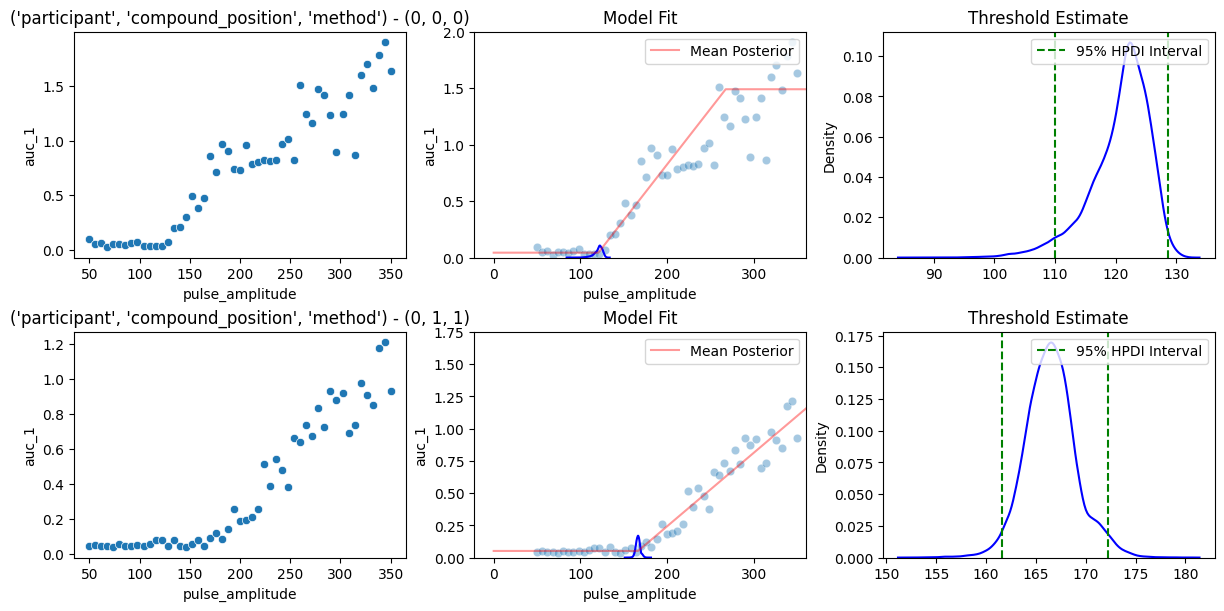

In [ ]:
model.plot(df=df, posterior_samples=posterior_samples);